In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

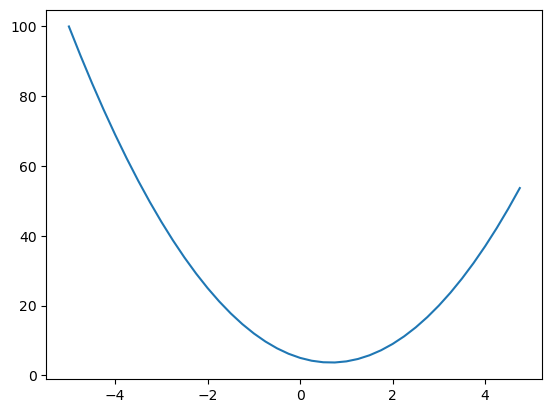

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
def slope(x):
    dx = 0.00001
    return (f(x + dx) - f(x)) / dx

In [6]:
slope(3)

14.00003000000538

In [7]:
slope(-3)

-21.999970000052823

In [8]:
class Value:
    def __init__(self, data, _children=(), op='', label=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = op
    
    def __repr__(self):
        return f"Value({self.label}, data={self.data})"
    
    def __add__(self, other):
        # Make sure other is a Value type.
        other = other if isinstance(other, Value) else Value(other)
        # Do operation and set children.
        out = Value(self.data + other.data, (self, other), '+')
        def _backfunc():
            """Backwards for add: accumulate the gradient."""
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backfunc
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        # Make sure other is a Value type.
        other = other if isinstance(other, Value) else Value(other)
        # Do operation and set children.
        out =  Value(self.data * other.data, (self, other), '*')
        def _backfunc():
            """Backwards for multiplication: accumulate the gradient times the current value."""
            self.grad  += other.data * out.grad
            other.grad += self.data  * out.grad
        out._backward = _backfunc
        return out
    
    def __rmul__(self, other):  # other * self case
        return self * other
    
    def __pow__(self, exponent):
        assert isinstance(exponent, (int, float)), "Only support int/float"
        out = Value(self.data**exponent, (self, ), f'**{exponent}')
        def _backfunc():
            """Backwards for powers: accumulate exponent * 1/value^(exponent) * gradient."""
            self.grad += exponent * (self.data**(exponent-1)) * out.grad
        out._backward = _backfunc
        return out

    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backfunc():
            """Backwards for exp: just the value times the gradient."""
            self.grad = out.data * out.grad
        out._backward = _backfunc
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backfunc():
            """Backwards for tanh: (1-tanh(x)^2) * gradient"""
            self.grad += (1 - t**2) * out.grad
        out._backward = _backfunc
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            """Build a recursive topographic map of all children."""
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0  # Reset gradient.
        for node in reversed(topo):
            node._backward()
        

In [9]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(, data=4.0)

In [10]:
t = a / c
t

Value(, data=0.2)

In [11]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

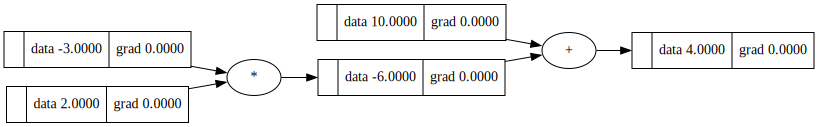

In [12]:
draw_dot(d)

In [13]:
# Simple network test.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value( 1.0, label='w2')
# Bias
b = Value(6.88137, label='b')
n = x1*w1 + x2*w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

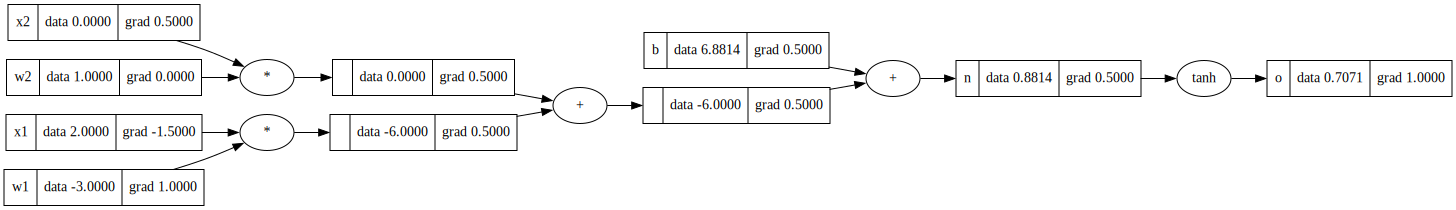

In [14]:
draw_dot(o)

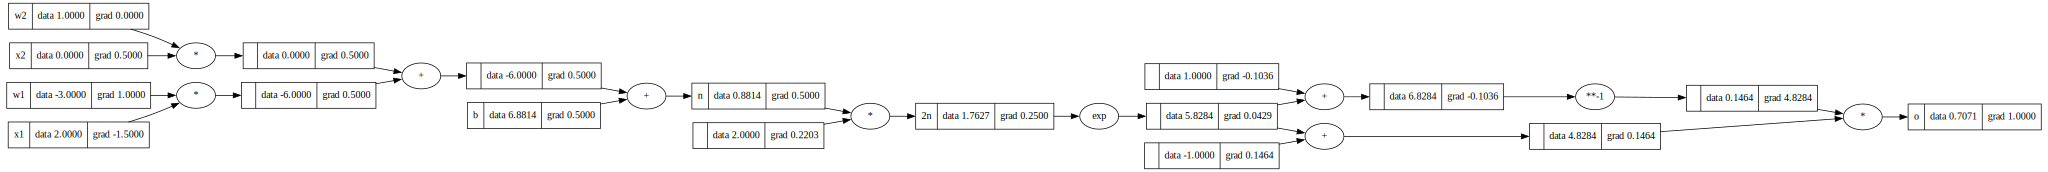

In [15]:
# Simple network test 2.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value( 1.0, label='w2')
# Bias
b = Value(6.88137, label='b')
n = x1*w1 + x2*w2 + b; n.label = 'n'
# spell out tanh(x)
temp = 2*n; temp.label='2n'
e = temp.exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [16]:
# Now do the same network with pytorch
import torch

x1 = torch.Tensor([ 2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([ 0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([ 1.0]).double(); w2.requires_grad = True
b  = torch.Tensor([6.88137]).double();   b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071050214706146
----
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [17]:
# Build a neuron class like torch
import random
class Neuron():
    def __init__(self, numdim, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(numdim)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        """Take an input x, and calculate an output and return it."""
        # Multiply each input by the corrisponding weight, then add b.
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()  # Apply nonlinearity.
        return out
    
    def parameters(self):
        return self.w + [self.b]

# A layer is a collection of neurons.
class Layer:
    def __init__(self, numin, numout):
        self.neurons = [Neuron(numin) for _ in range(numout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # If we just have a single neuron, just return that single output.
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# A multi-layer perceptron has several layers.
class MLP:
    def __init__(self, numin, numouts):
        # To make iterating easier, make one list.  The number of inputs
        # to the next layer is the same as the number of outputs of the
        # previous layer.
        size = [numin] + numouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(numouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            # The output of the layer is the new input for the next
            # layer, so we can just re-use x over and over.
            x = layer(x)
        return x  # Final output can return.
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# To create the diagram of the MLP, it has 3 inputs, 4 neurons, then 4 neurons, then single output.
layer_neuron_counts = [4, 4, 1]
x = [2.0, 3.0, -1]  # 3 dimensional input.
mlp = MLP(3, layer_neuron_counts)
mlp(x)

Value(, data=-0.39607600915829194)

In [18]:
len(mlp.parameters())

41

In [19]:
# Example data set with 4 examples.
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]  # Desired targets.

In [20]:
# Build a training loop.
for k in range(100):
    # Forward pass.
    ypred = [mlp(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Backward pass.
    for p in mlp.parameters():
        p.grad = 0.0  # Reset grads before the pass!!
    loss.backward()

    # Update the weights and biases.
    for p in mlp.parameters():
        p.data += -0.01 * p.grad
    
    print(k, loss.data)

0 5.1638763348894265
1 4.93245666861816
2 4.727722876000722
3 4.5495292869090305
4 4.396148927981725
5 4.264285753555295
6 4.149756263886131
7 4.04824324309995
8 3.9558134917719396
9 3.8691504331003026
10 3.785580952461483
11 3.702996193299873
12 3.6197391365121643
13 3.5344991180007446
14 3.446230209688495
15 3.3540975102251624
16 3.257449434771014
17 3.1558116936302483
18 3.048897598170045
19 2.9366284983245796
20 2.819157214326452
21 2.696886542284232
22 2.5704749317697493
23 2.440822945851514
24 2.3090374098943083
25 2.1763747378362646
26 2.044169508599925
27 1.9137574193330547
28 1.7864023050324565
29 1.6632351082945098
30 1.5452095376371067
31 1.4330759167518754
32 1.3273722291296264
33 1.22842982093781
34 1.1363904622719696
35 1.0512312233244616
36 0.9727937276704517
37 0.9008147199005241
38 0.8349554693450186
39 0.7748282396837219
40 0.7200187779733277
41 0.6701044171254843
42 0.6246678795745771
43 0.5833071963646602
44 0.5456423294134165
45 0.5113191388911269
46 0.480011311283

In [21]:
# Forward pass and check.
ypred = [mlp(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(, data=0.07769617413609499)

In [22]:
ypred

[Value(, data=0.8945185304284828),
 Value(, data=-0.9183606652021075),
 Value(, data=-0.8058831081231761),
 Value(, data=0.8509245660245554)]